# 1st Spectrum Test in periodic Cube
In this notebook, we will test the spectrum of MHDFlows using A99 Turbulence Driving Scheme from [Alvelius
1999]( https://doi.org/10.1063/1.870050)

In [1]:
using PyPlot
using CUDA
using Statistics
using FFTW
using LinearAlgebra: mul!, ldiv!

using FourierFlows
using MHDFlows
using MHDFlows:GetA99vars_And_function,SetUpFk

┌ Info: FourierFlows will use 8 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/IWexK/src/FourierFlows.jl:123


In [2]:
# Declare the problem on CPU/GPU
dev = GPU();
T  = Float32;

nx,ny,nz = 250,250,250;
Lx,Ly,Lz = 2π,2π,2π;

Re = 1e4;
L  = Lx;
U  = 1;
ν  = U*L/Re
η  = ν; 

A99_var, A99Forcing! = GetA99vars_And_function(dev,nx,ny,nz;T=T)

CPUprob =       Problem(dev;
     # Numerical parameters
                   nx = nx,
                   Lx = Lx,
      # Drag and/or hyper-viscosity for velocity/B-field
                    ν = ν,
                   nν = 0,
                    η = η,
                   nη = 0,
      # Declare if turn on magnetic field, VP method, Dye module
       	      B_field = false,
            VP_method = false,
           Dye_Module = false,
     # Timestepper and equation options
              stepper = "RK4",
                calcF = A99Forcing!,
     # Float type and dealiasing
                    T = T,
     aliased_fraction = 1/3,
     # User defined params/vars
             usr_vars = A99_var,
           usr_params = [],
             usr_func = [])

MHDFlows Problem
  │    Funtions
  │     ├──────── B-field: OFF
  ├─────├────── VP Method: OFF
  │     ├──────────── Dye: OFF
  │     └── user function: OFF
  │                        
  │     Features           
  │     ├─────────── grid: grid (on GPU)
  │     ├───── parameters: params
  │     ├────── variables: vars
  └─────├─── state vector: sol
        ├─────── equation: eqn
        ├────────── clock: clock
        └──── timestepper: RK4TimeStepper

In [3]:
function ProblemGeneratorA99!(prob;P=1,σ² =1,kf=12,L0=2π)
  # Output Setting  
  x,y,z    = Array(prob.grid.x), Array(prob.grid.y), Array(prob.grid.z);
  nx,ny,nz = prob.grid.nx,prob.grid.ny,prob.grid.nz;
  @devzeros  typeof(CPU()) T (nx,ny,nz) ux uy uz bx by bz

  SetUpFk(prob; kf = kf, P = P,σ²= σ²)
  for k ∈ 1:nz::Int,j ∈ 1:ny::Int,i ∈ 1:nx::Int
      @simd for kk = 1:5
          nothing;
      end
  end

  #Update V + B Conponment to Problem
  SetUpProblemIC!(prob; ux = ux, uy = uy, uz = uz);

end

ProblemGeneratorA99! (generic function with 1 method)

In [4]:
ProblemGeneratorA99!(CPUprob; P=2e1,σ² =4, kf=2, L0=2π);

In [5]:
CPUprob.vars.usr_vars.b = 0.5

0.5

In [6]:
function GetU²(prob)
    ux,uy,uz = prob.vars.ux,prob.vars.uy,prob.vars.uz;
    dV = prob.grid.dx*prob.grid.dy*prob.grid.dz;
    U2 = sum(ux.^2 .+ uy.^2 .+ uz.^2)*dV;
    return U2;
end
U2 = MHDFlows.Diagnostic(GetU², CPUprob,freq=5);

In [7]:
# Set up the initi0l condition
#CPUprob.clock.t = 0
@CUDA.time TimeIntegrator!(CPUprob,30.0,10000;
                              CFL_Coef = 0.2,
                                 diags = [U2],
                           loop_number = 500);

n =      500, t =     5.12, KE =     14.4
n =     1000, t =     8.53, KE =     19.8
n =     1500, t =     12.0, KE =     21.4
n =     2000, t =     15.1, KE =     20.6
n =     2500, t =     18.2, KE =     20.3
n =     3000, t =     21.5, KE =     18.6
n =     3500, t =     25.0, KE =     17.2
n =     4000, t =     28.4, KE =     18.7
Total CPU/GPU time run = 2237.474 s, zone update per second = 2.9504530458e7 
2239.103483 seconds (147.68 M CPU allocations: 12.244 GiB, 0.81% gc time) (433.54 k GPU allocations: 24.253 TiB, 46.33% memmgmt time)


# Analysis

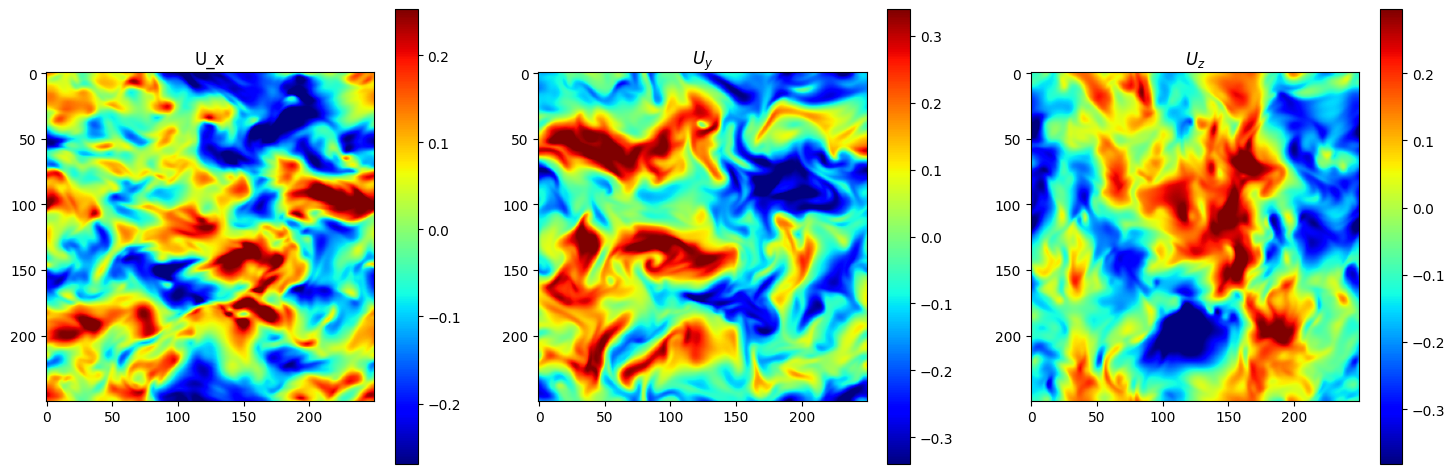

PyObject <matplotlib.colorbar.Colorbar object at 0x7f212f62d6a0>

In [17]:
function imshow_with_sd(A; cmap="jet",Colorbar=true)
    m,σ = mean(A[.~isnan.(A)]),std(A[.~isnan.(A)]);
    imshow(A,vmin=m-2σ,vmax=m+2σ,cmap=cmap);
    Colorbar ? colorbar() : nothing
end

Ux,Uy,Uz = Array(CPUprob.vars.ux),Array(CPUprob.vars.uy),Array(CPUprob.vars.uz);

figure(figsize=(18,13))
subplot(231);title("U_x")
imshow_with_sd(Ux[:,div(nx,2),:]';cmap="jet")
subplot(232);title(L"U_y")
imshow_with_sd(Uy[:,div(nx,2),:]';cmap="jet")
subplot(233);title(L"U_z")
imshow_with_sd(Uz[:,div(nx,2),:]';cmap="jet")

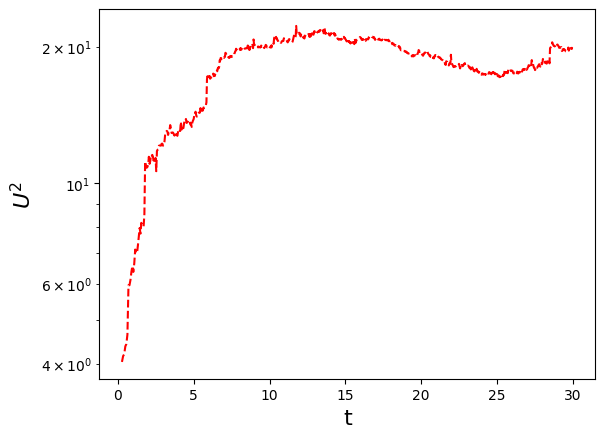

PyObject Text(35.2, 0.5, '$U^2$')

In [9]:
n = U2.i;
t = U2.t;
plot(t[2:n],U2.data[2:n],"r--")
semilogy()
xlabel("t",size=16)
ylabel(L"U^2",size=16)

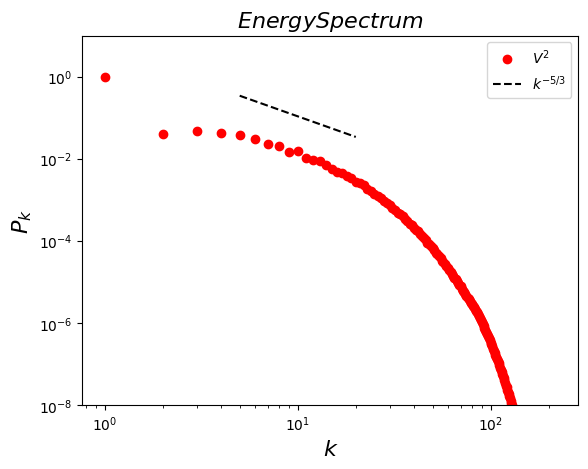

PyObject <matplotlib.legend.Legend object at 0x7f2143f00b70>

In [11]:
U2T = Ux.^2 + Uy.^2 + Uz.^2; 
y,x = spectralline(Array(U2T));
loglog(x,y/y[1],"ro",label=L"V^2");
loglog(x[5:20],5*x[5:20].^(-5/3),"k--",label=L"k^{-5/3}");

ylabel(L"P_k}",size=16)
xlabel(L"k",size=16)
title(L"Energy Spectrum",size=16)
ylim(1e-8,1e1)
legend()